In [1]:
import numpy as np
import pandas as pd
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os
from IPython.core.display import Image, display

from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

# PRACTICEs

After building a `simple database`, it's now time to make use of the features. You'll specify `data types` in columns, `enforce` column `uniqueness`, and `disallow NULL values` in this chapter.

## 1. Better data quality with constraints

#### 1.1. Integrity constraints

        |====================================================================================================|
        | (1): ATTRIBUTE CONSTRAINTs               | E.g. data types in column [Chapter 2 : this chapter]    |
        | (2) : KEY CONSTRAINTs                    | E.g. primary keys [Chapter 3]                           |
        | (3) : REFERENTIAL INTEGRITY CONSTRAINTs  | Enforced through the foreign keys [Chapter 4]           |
        |====================================================================================================|
        
**Reason: why constraints?**            

            i) Gives the data structure
           ii) Help with consitency and thus data quality
          iii) Data quality is a business advantage / data science prerequisite
           iv) Enforcing is difficult but the PostgreSQL helps

#### 1.2. Data type as attribute constraints           

| Name                      |    Aliases         | Descriptions                              |
|---------------------------|--------------------|-------------------------------------------|
| bigint                    |  int8              |  `signed` ***8-byte integer***            |
| bigserial                 |  serial8           |  `auto-incrementing` ***8-byte integer*** |
| bit [(n)]                 |                    |  `fixed-length` ***bit-string***          |          
| bit varying [ (n)]        |  varbit [ (n) ]    |  `variable-length` ***bit-string***       |
| boolean                   |  bool              |  `logical Boolean` : true / false         |
| box                       |                    |  `rectangular box` on a `plane`           |
| bytea                     |                    |  binary data (***`"data array"`***)       |
| character [ (n) ]         |  char [ (n) ]      |  `fixed-length` ***character string***    |
| character varying [ (n) ] |  varchar [ (n) ]   |  `variable-length` ***character string*** |
| cidr                      |                    |  `IPv4` or `IPv6` network address         |
|---------------------------|--------------------|-------------------------------------------|

#### 1.3. Dealing with data_types.

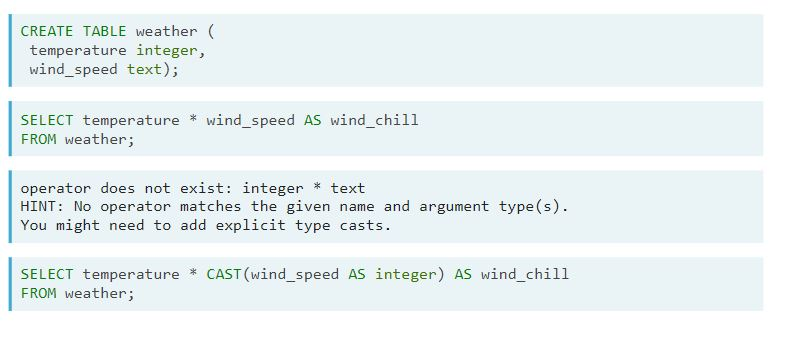

In [2]:
### Look at the following figure

### EXERCISEs.

#### Q1.1 Types of database constraints
Which of the following is **not used** to enforce a database constraint?

            A. Foreign keys                                C. The BIGINT data type
            B. SQL aggregate functions                     D. Primary keys
**Answers**: `B. SQL aggregate functions`. Noting that they are not used to enforce constraints, but to do calculations on data.




#### Q 1.2. Conforming with data types
For demonstration purposes, I created a fictional database table that only holds three records. The columns have the data types `date`, `integer`, and `text`, respectively.

            CREATE TABLE transactions (
             transaction_date date, 
             amount integer,
             fee text
            );
Have a look at the contents of the `transactions` table.

The `transaction_date` accepts date values. According to the [PostgreSQL documentation](https://www.postgresql.org/docs/10/datatype-datetime.html#DATATYPE-DATETIME-INPUT), it accepts values in the form of `YYYY-MM-DD`, `DD/MM/YY`, and so forth.

Both columns `amount` and `fee` appear to be numeric, however, the latter is modeled as `text` – which you will account for in the next exercise.

#### Instructions
Execute the given sample code.

                -- Let's add a record to the table
                INSERT INTO transactions (transaction_date, amount, fee) 
                VALUES ('2018-24-09', 5454, '30');

                -- Doublecheck the contents
                SELECT *
                FROM transactions;
                
As it doesn't work, have a look at the `error message` and correct the statement accordingly – then execute it again.

**Solutions**

First, when **running the sample code**, the `error message` warns the `mistake` at `date/time field value` is out of range!

        date/time field value out of range: "2018-24-09"
        LINE 3: VALUES ('2018-24-09', 5454, '30');
                        ^
        HINT:  Perhaps you need a different "datestyle" setting.
We had known that the ISO format of `date-time data type` is `yyyy-mm-dd` so the value here `2018-24-09` will be a wrong format! So we will change it into `2018-09-24` and let's see the query result

**Correct the statement**

            INSERT INTO transactions (transaction_date, amount, fee) 
            VALUES ('2018-09-24', 5454, '30');
            -- Doublecheck the contents
            SELECT *
            FROM transactions;
**query result**

| transaction_date | amount   | fee   |
|------------------|----------|-------|
| 1999-01-08       | 500	  | 20    |
| 2001-02-20	   | 403	  | 15    |
| 2001-03-20	   | 3430	  | 35    |
| 2018-09-24	   | 5454	  | 30    |

Good work. You can see that `data types` provide certain ***restrictions*** on how data can be entered into a table. This may be tedious at the moment of insertion, but saves a lot of headache in the long run.

#### Q 1.3. Type CASTs
In the preceding section, we saw that type casts are a possible solution for data type issues. If you know that a certain column stores numbers as text, you can cast the column to a numeric form, i.e. to integer.

                SELECT CAST(some_column AS integer)
                FROM table;
Now, the some_column column is temporarily represented as integer instead of text, meaning that you can perform numeric calculations on the column.

#### Instructions
Again, execute the given sample code. As it doesn't work, add an integer type cast at the right place and execute it again.

The given sample code:

                -- Calculate the net amount as amount + fee
                SELECT transaction_date, amount + fee AS net_amount 
                FROM transactions;

**Solution.**

**Result (When excuting the sample code)!**

            operator does not exist: integer + text**
            LINE 2: SELECT transaction_date, amount + fee AS net_amount 
                                                    ^
            HINT:  No operator matches the given name and argument types. You might need to add explicit type casts.
**Fixed code!** CAST the `fee` as an integer then add it to `amount`

            -- Calculate the net amount as amount + fee
            SELECT transaction_date, amount + CAST(fee AS integer) AS net_amount
            FROM transactions;
**query result.**

|transaction_date|net_amount|
|----------------|----------|
|1999-01-08|520|
|2001-02-20|418|
|2001-03-20|3465|
|1999-01-08|520|
|2001-02-20|418|
|2001-03-20|3465|
|2018-09-24|5484|
|1999-01-08|520|
|2001-02-20|418|
|2001-03-20|3465|
|1999-01-08|520|
|2001-02-20|418|
|2001-03-20|3465|
|2018-09-24|5484|

Good job! You saw how, sometimes, type casts are necessary to work with data. However, it is better to store columns in the right data type from the first place. You'll learn how to do this in the next exercises.

## 2. Working with data types

Includes: 
> `Enforced` on columns (i.e. attributes)
>
> Defined the so-called `"domain"` of a column
>
> Defined what operators is possible
>
> Enforce a consistence storage of values

### The most common types:

| Data type | Descriptions |
|-----------|---------------
| text      | character string of any length|
| varchar [(n)] | a maximum of `n` characters |
| char [(n)] | a fixed-length string of `n` characters |
| boolean | take one of the statement: `TRUE, FALSE` and `NULL` (or `None`, the unknown data) |
| date, date-time & timestamp | various formats of date and time calculations |
| numeric | arbitrary precision number; e.g.3.1457 |
| integer | whole number in range `-214748364848` to `214748364847` |

**Specifying datatype upon table creation**

            CREATE TABLE student (
                                    ssn integer,
                                    name varchar(64),
                                    dob date,  -- dob = date of birth
                                    average_grade numeric(3, 2), -- e.g. 5.54
                                    tuitition_paid boolean
                                    );
                                    
           -- ALTER TYPE AFTER CREATE TABLE                             
           -- 1) add a column name to varchar(128)
           ALTER TABLE student
           ALTER COLUMN name
           TYPE varchar(128);
           
           -- 2) alter average_grade to be rounded up
           ALTER TABLE student
           ALTER COLUMN average_grade
           TYPE integer   -- before is numeric(3, 2)
           USING ROUND(average_grade)  -- Turns 5.54 into 6, not 5 before type_consversion.

### EXERCISEs

#### Question 2.1. Change types with ALTER COLUMN
The syntax for changing the data type of a column is straightforward. The following code changes the data type of the `column_name` column in `table_name` to `varchar(10)`:

                ALTER TABLE table_name
                ALTER COLUMN column_name
                TYPE varchar(10)
Now it's time to start adding constraints to your database.

#### Instructions
**Step 1.** Have a look at the distinct `university_shortname` values in the `professors` table and take note of the length of the strings.

**Solution.**

                -- Select the university_shortname column
                SELECT COUNT(DISTINCT university_shortname) 
                FROM professors;
**query result.**

| university_shortname |
|----------------------|
| ETH
| UNE
| EPF
| UGE
| UZH
| USI
| UFR
| UBA
| USG
| ULA
| UBE


**Step 2.** Now specify a fixed-length character type with the correct length for `university_shortname`.

**Solution**

                    -- Specify the correct fixed-length character type
                    ALTER TABLE professors
                    ALTER COLUMN university_shortname
                    TYPE char(3);


**Step 3.** Change the type of the firstname column to `varchar(64)`

**Solution.**

                    -- Change the type of firstname
                    -- Specify the correct fixed-length character type
                    ALTER TABLE professors
                    ALTER COLUMN firstname
                    TYPE varchar(64);

#### Question 2.2. Convert types USING a function
If you don't want to reserve too much space for a certain varchar column, you can truncate the values before converting its type.

For this, you can use the following syntax:

                ALTER TABLE table_name
                ALTER COLUMN column_name
                TYPE varchar(x)
                USING SUBSTRING(column_name FROM 1 FOR x)
You should read it like this: Because you want to reserve only `x characters` for `column_name`, you have to retain a SUBSTRING of every value, i.e. the first `x` characters of it, and throw away the rest. This way, the values will fit the `varchar(x)` requirement.

#### Instructions
**Step 1.** Run the sample code as is and take note of the error.

**`Sample code`**

                -- Convert the values in firstname to a max. of 16 characters
                ALTER TABLE professors 
                ALTER COLUMN firstname 
                TYPE varchar(16)
**`Error` messages.**

            value too long for type character varying(16)
**Explain.** Some of the column `firstname` contains more than 17 characters; so this exceed the `maximum_limit` of characters when using the statement: `varchar(16)`! 

**Step 2.** Now use `SUBSTRING()` to reduce firstname to 16 characters so its type can be altered to `varchar(16)`

**Solution.**

                -- Convert the values in firstname to a max. of 16 characters
                ALTER TABLE professors 
                ALTER COLUMN firstname 
                TYPE varchar(16)
                USING SUBSTRING(firstname FROM 1 FOR 16);

Perfect! However, it's best not to truncate any values in your database, so we'll revert this column to `varchar(64)`. Now it's time to move on to the next set of attribute constraints!

## 3. The not-null and unique constraints

Notes on the **`not-null` constraints**.

> Disallow `NULL` value in a certain column
>
> Must hold true for the current state and for any future state.

So, what does the `NULL` variable means? **`unknown`, `doesn't exist`** and **`doesn't apply`**. For example

            CREATE TABLE student (
                                    ssn integer not null,
                                    name varchar(64) not null,
                                    dob date,  -- dob = date of birth
                                    home_phone integer,
                                    office_phone integer
                                    );
            NULL != NULL

#### 3.1 How to add or remove a `NOT NULL constraints`
After the table has been created as before, then 

     -- ADD the `NOT NULL CONSTRAINTs`   ||    -- REMOVE the `NOT NULL CONSTRAINTs`
     -- Make home_phone to be NOT NULL   ||
     ====================================||=======================================
     ALTER TABLE student                 ||      ALTER TABLE student
     ALTER COLUMN home_phone             ||      ALTER COLUMN ssn
     SET NOT NULL;                       ||      DROP NOT NULL;
     
#### 3.2. The unique constraints and how to add them?
First, look at the following picture

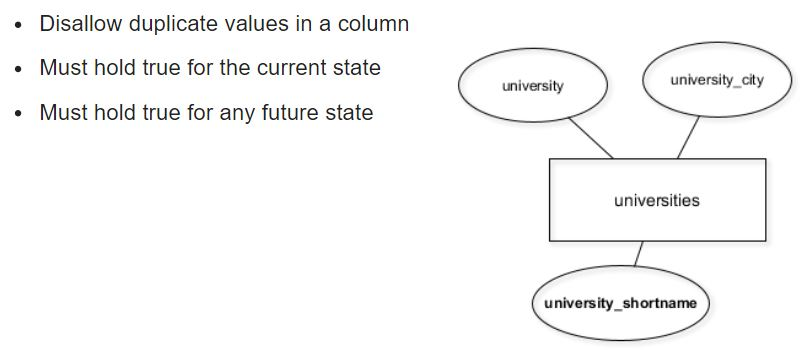

In [3]:
## hidden ---
display(Image(r"/kaggle/input/server-database/fig2_2.JPG", width=630, unconfined=True))

Then, to add a `unique constraints` into database, we do the same thing as the following syntax:

                CREATE TABLE table_name(
                                          column_name UNIQUE
                                        );
                                        
               ALTER TABLE table_name
               ADD CONSTRAINT some_name UNIQUE(column_name)

### EXERCISEs

#### Exercise 3.1. Disallow `NULL` values with `SET NOT NULL`
The professors table is almost ready now. However, it still allows for **`NULLs`** to be entered. Although some information might be missing about some professors, there's certainly columns that always need to be specified.

#### Instructions 
**Step 1.** Add a `not-null constraint` for the `firstname` column.

**Solution.**

                -- Disallow NULL values in firstname
                ALTER TABLE professors 
                ALTER COLUMN firstname SET NOT NULL;
**Step 2.** Add a `not-null constraint` for the `lastname` column

**Solution.**

                -- Disallow NULL values in firstname
                ALTER TABLE professors 
                ALTER COLUMN lastname SET NOT NULL;

Good job – it is no longer possible to add professors which have either their first or last name set to `NULL`. Likewise, it is no longer possible to update an existing professor and setting their first or last name to `NULL`.

#### Exercise 3.2. What happens if you try to enter NULLs?
Execute the following statement:

        INSERT INTO professors (firstname, lastname, university_shortname)
        VALUES (NULL, 'Miller', 'ETH');
Why does this throw an error?
A. Professors without `first names` do not exist.

B. Because a `database constraint` is violated.

C. `Error`? This works just fine.

D. `NULL` is not put in quotes.

    ===========================
    Answers
    ===============
*A. Wrong submission!* Well, this might be the case in reality, but the database wouldn't know that by itself. No, the error happens specifically because of something you did to the database in the last exercise.!

**B. Correct!** This statement violates one of the not-null constraints you've just specified.

*C. Wrong submission!* Well, that is weird. Since you've added a not-null constraint in the previous exercise, the insertion of **`NULLs`** into any of the `professors` columns should no longer be possible.

*D. Wrong submission!* Well, almost. If **NULL** was put in quotes, it would be accepted as a valid value for `firstname`. However, this is not the actual reason for the error. Inserting a character value of **'NULL'** wouldn't really make sense, anyway.

===========================================================

#### Exercise 3.3. Make your columns UNIQUE with ADD CONSTRAINT
As seen in this section, you add the **`UNIQUE` keyword** after the `column_name` that should be **unique**. This, of course, only works for new tables:

                CREATE TABLE table_name (
                 column_name UNIQUE
                );
If you want to add a unique constraint to an existing table, you do it like that:

                ALTER TABLE table_name
                ADD CONSTRAINT some_name UNIQUE(column_name);
Note that this is different from the `ALTER COLUMN syntax` for the `not-null constraint`. Also, you have to give the constraint a name `some_name`.

#### Instructions
**Step 1.** Add a `unique constraint` to the `university_shortname` column in `universities`. Give it the name `university_shortname_unq`.

**Solution.**

                -- Make universities.university_shortname unique
                ALTER TABLE universities
                ADD CONSTRAINT university_shortname_unq UNIQUE(university_shortname);
**Step 2.** Add a `unique constraint` to the `organization` column in `organizations`. Give it the name `organization_unq`.

**Solution.**

                -- Make organizations.organization unique
                ALTER TABLE organizations
                ADD CONSTRAINT organization_unq UNIQUE(organization);

Perfect. Making sure `universities.university_shortname` and `organizations.organization` only contain unique values is a prerequisite for turning them into so-called primary keys – the subject of the next chapter!